## Applying Transfer Learning

### 1. Creating DF for all images

In [1]:
import os
import pandas as pd

# Step 1: Collect image paths and metadata into a DataFrame
def collect_image_paths(root_dir):
    data = []
    
    # Walk through each directory
    for class_folder in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_folder)
        print(class_path)
        if os.path.isdir(class_path):
            for split in ['Train', 'Test']:
                split_path = os.path.join(class_path, split)
                
                if os.path.isdir(split_path):
                    for image_name in os.listdir(split_path):
                        image_path = os.path.join(split_path, image_name)
                        data.append({
                            'path': image_path,
                            'target': class_folder,
                            'split': split
                        })
    
    return data

# Set the root directory of your dataset
root_dir = '/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification'

# Collect the data
data = collect_image_paths(root_dir)

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Spiral Fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Impacted fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Greenstick fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Pathological fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Oblique fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Fracture Dislocation
/k

In [2]:
import numpy as np

# Assuming your DataFrame is named df and it has a 'split' column
# Shuffle the DataFrame to ensure randomness
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the number of rows for each split
n_total = len(df_shuffled)
n_train = int(0.80 * n_total)
n_val = int(0.05 * n_total)
n_test = n_total - n_train - n_val

# Assign new splits
df_shuffled.loc[:n_train, 'split'] = 'train'
df_shuffled.loc[n_train:n_train + n_val, 'split'] = 'validation'
df_shuffled.loc[n_train + n_val:, 'split'] = 'test'

# Check the distribution of the new split
print(df_shuffled['split'].value_counts())

split
train         903
test          170
validation     56
Name: count, dtype: int64


In [3]:
df_shuffled.head()

,path,target,split
0,/kaggle/input/bone-break-classification-image-...,Oblique fracture,train
1,/kaggle/input/bone-break-classification-image-...,Comminuted fracture,train
2,/kaggle/input/bone-break-classification-image-...,Comminuted fracture,train
3,/kaggle/input/bone-break-classification-image-...,Spiral Fracture,train
4,/kaggle/input/bone-break-classification-image-...,Pathological fracture,train


### 2: Data Loader with Augmentation on training

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have a DataFrame with columns: ['path', 'target', 'split']
# 'path' should contain the full path to the image
# 'target' should contain the class label
# 'split' should contain 'train', 'validation', or 'test'


# Define image size and batch size
image_size = (256, 256)
batch_size = 16

# Create an ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=60,
    width_shift_range=[-30, -20, -10, 0, 10, 20, 30],
    height_shift_range=[-30, -20, -10, 0, 10, 20, 30],
    fill_mode='constant',
    cval=0  # Fill empty areas with black
)

# For validation and test data, only rescale (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create separate DataFrames for each split
train_df = df_shuffled[df_shuffled['split'] == 'train']
val_df = df_shuffled[df_shuffled['split'] == 'validation']
test_df = df_shuffled[df_shuffled['split'] == 'test']

# Flow from DataFrame for training data
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',  # Column with the image paths
    y_col='target',  # Column with the labels
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Adjust if you need binary or other modes
    shuffle=True,
    seed=42
)

# Flow from DataFrame for validation data
val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='target',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Flow from DataFrame for test data
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='target',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 903 validated image filenames belonging to 10 classes.
Found 56 validated image filenames belonging to 10 classes.
Found 170 validated image filenames belonging to 10 classes.


### 3: Ploting some images from train test and validation

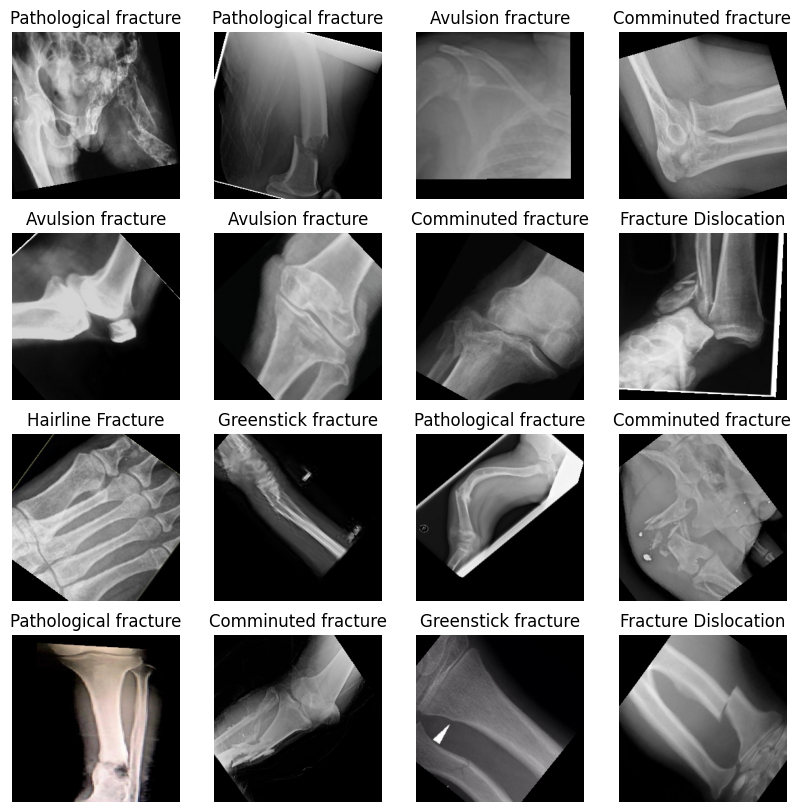

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot augmented images along with class names
def plot_augmented_images(generator, num_images):
    # Get a batch of augmented images and labels
    x_batch, y_batch = next(generator)
    
    # Get the class names from the generator
    class_indices = generator.class_indices
    # Invert the class indices to get a mapping from index to class name
    index_to_class = {v: k for k, v in class_indices.items()}

    # Plot the images in a grid with their class names
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(num_images//4, 4, i + 1)
        img = x_batch[i]
        # Get the index of the class (from one-hot encoded label)
        class_index = np.argmax(y_batch[i])
        class_name = index_to_class[class_index]
        
        plt.imshow(img)
        plt.title(class_name)  # Display the class name
        plt.axis('off')
    plt.show()



# Display 16 augmented Training images
plot_augmented_images(train_generator, num_images=batch_size)

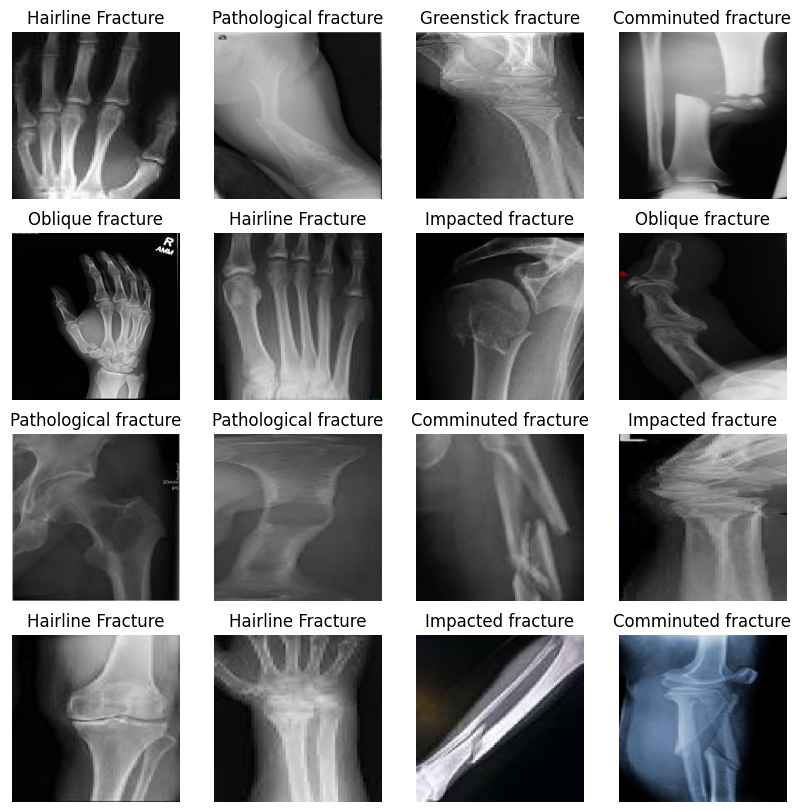

In [6]:
# Display 16 Testing images
plot_augmented_images(test_generator, num_images=batch_size)

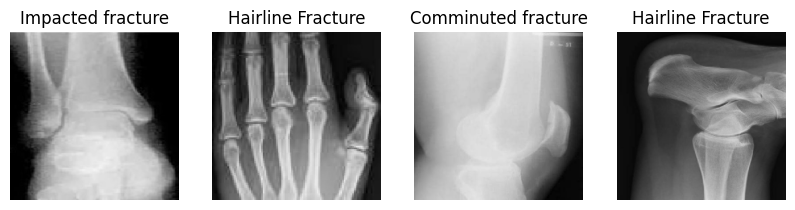

In [7]:
# Display 4 Validation images
plot_augmented_images(val_generator, num_images=4)

### 3: Applying Transfer Learning

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [9]:
# Number of classes in your dataset
num_classes = 10

# Image size (256x256x3)
image_size = (256, 256, 3)

# Load the pre-trained ResNet50 model, excluding the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size)

# Make the last 5 layers trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build custom model on top of the ResNet50 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units and ReLU activation
x = Dropout(0.5)(x)  # Dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 24,061,706 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
train_generator.reset()
val_generator.reset()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Set the number of epochs according to your needs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 486s 8s/step - accuracy: 0.1361 - loss: 2.7473 - val_accuracy: 0.1458 - val_loss: 11.6153 - learning_rate: 0.0010
Epoch 2/20
 1/56 ━━━━━━━━━━━━━━━━━━━━ 7:00 8s/step - accuracy: 0.1875 - loss: 2.2906

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1875 - loss: 2.2906 - val_accuracy: 0.1250 - val_loss: 13.1893 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 433s 8s/step - accuracy: 0.1144 - loss: 2.3067 - val_accuracy: 0.1250 - val_loss: 5.9285 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.1250 - loss: 2.2655 - val_accuracy: 0.0000e+00 - val_loss: 7.6948 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 440s 8s/step - accuracy: 0.1328 - loss: 2.2872 - val_accuracy: 0.1250 - val_loss: 2.3030 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.1250 - loss: 2.3473 - val_accuracy: 0.0000e+00 - val_loss: 2.3147 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 439s 8s/step - accuracy: 0.1387 - loss: 2.2936 - val_accuracy: 0.0833 - val_loss: 2.3030 - learning_rate: 0.0010
Epoch 8/20
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - accuracy: 0.0625 - loss: 2.3067
Epoch 8: Re

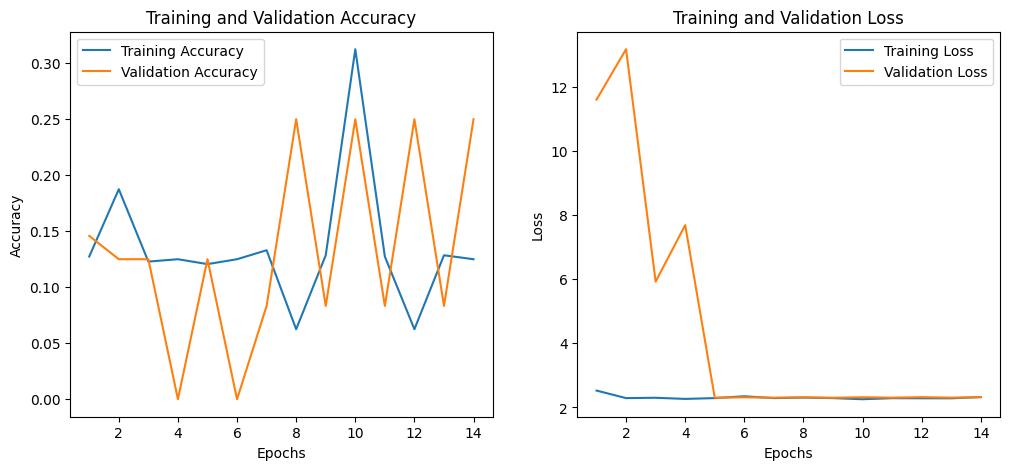

In [11]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Extract data from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history)

In [12]:
test_generator.reset()
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc}")

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1185 - loss: 2.2875
Test Accuracy: 0.16249999403953552
